In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.DBLP import DBLP
import dgl.function as fn
import torch
import numpy as np
import torch_geometric
torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/scratch/0994359/hetero-conv-matching/.venv/lib64/python3.9/site-packages/torch

In [2]:

dataset = DBLP() 
original_graph = dataset.load_graph(n_components=30)
device= "cuda:3"
original_graph = original_graph.to(device)


In [ ]:

num_nearest_init_neighbors_per_type = {"papertoauthor": 50, "authortopaper": 50, "conferencetopaper":50, "papertoconference":50,"papertoterm":50, "termtopaper":50, "author":50 , "paper":50, "conference": 50, "term":50}
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, use_zscore=False,device=device,
                                cca_cls=CCA, batch_size=None, checkpoints=[0.9, 0.5, 0.3], folder_name="dblp_cca_pca_30_add_feat_true_2",
                                pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


authortopaper
conferencetopaper
papertoauthor
papertoconference
papertoterm
termtopaper
step: 0, ratio: 1.0
step: 1, ratio: 0.9995407225964482
step: 2, ratio: 0.9990814451928965
step: 3, ratio: 0.9986221677893448
step: 4, ratio: 0.998162890385793
step: 5, ratio: 0.9977036129822413
step: 6, ratio: 0.9972443355786895
step: 7, ratio: 0.9967850581751377
step: 8, ratio: 0.9963257807715861
step: 9, ratio: 0.9958665033680343
step: 10, ratio: 0.9954072259644825
step: 11, ratio: 0.9949479485609308
step: 12, ratio: 0.994488671157379
step: 13, ratio: 0.9940293937538273
step: 14, ratio: 0.9935701163502756
step: 15, ratio: 0.9931108389467238
step: 16, ratio: 0.9926898346601347
step: 17, ratio: 0.9922688303735456
step: 18, ratio: 0.9918478260869565
step: 19, ratio: 0.9914268218003675
step: 20, ratio: 0.9910058175137784
step: 21, ratio: 0.9905848132271893
step: 22, ratio: 0.9901638089406001
step: 23, ratio: 0.989742804654011
step: 24, ratio: 0.9893218003674219
step: 25, ratio: 0.9889007960808328
step

In [3]:
import pickle
with open(f'results/dblp_cca_pca_30_add_feat_true_2/0.3', 'rb') as fh:
        
    coarsener = pickle.load(fh) 

In [4]:

coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("author")
coarsener.make_mask(mapping, "author")

labels = coarsener.get_labels(mapping, "author")
coarsend_graph.nodes["author"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=coarsend_graph.device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.29998469075321493


In [5]:
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 

ratio 0.29998469075321493


In [6]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSage import HeteroSAGE
from Models.HeteroSGC import HeteroSGCPaper

from Experiments.model_helper import run_experiments

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  HeteroSGCPaper,
                                                  model_param={"hidden_dim": 64,"num_layers":3},
                        optimizer_param={"lr": 0.01, "weight_decay": 5e-4},
                        num_runs=1, epochs=200,eval_interval=1, target_node_type="author")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line


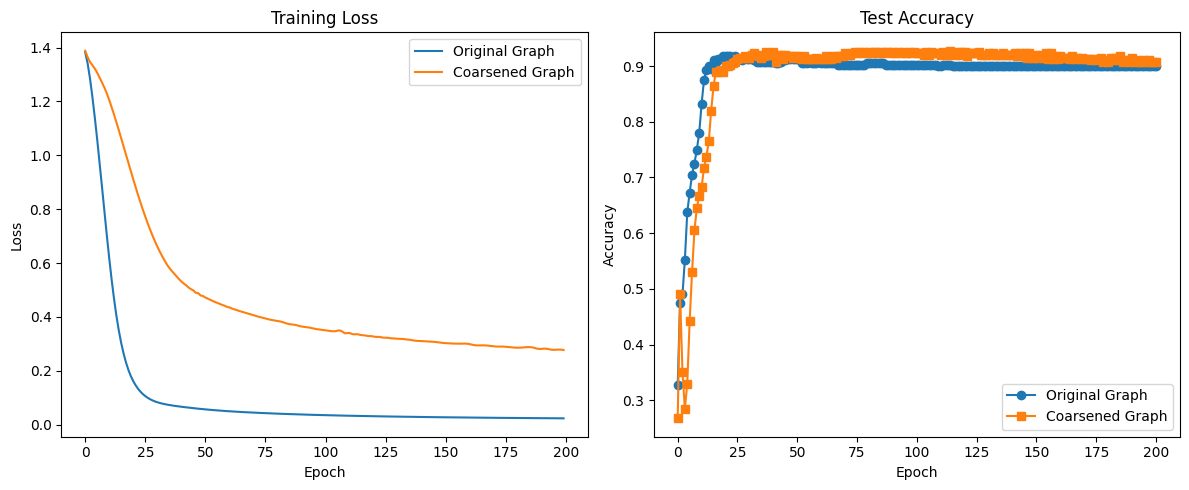

Final Performance Comparison:
Original Graph Accuracy: 0.9000
Coarsened Graph Accuracy: 0.9075

Original Graph Accuracy:
  Mean: 0.9000
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.9075
  Std:  0.0000


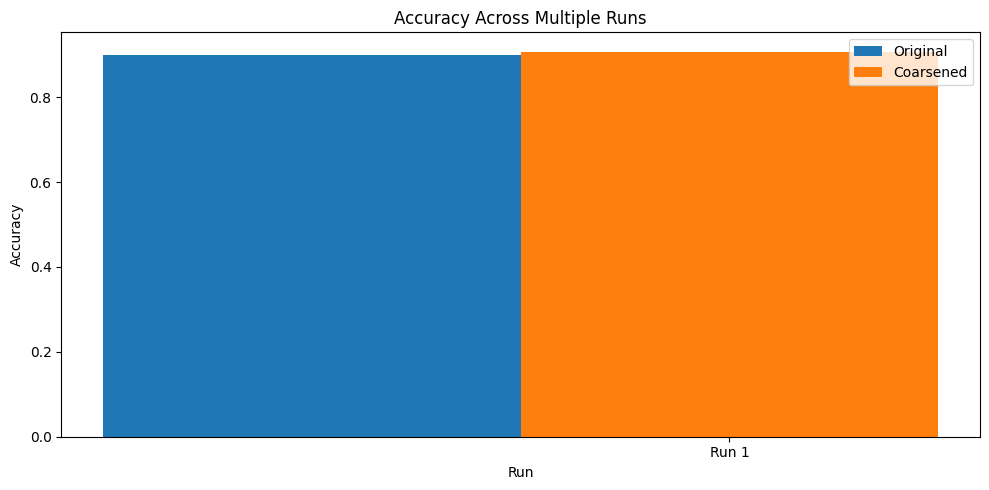

In [7]:

epochs = list(range(200))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)